<a href="https://colab.research.google.com/github/jyj1206/StandaloneDeepLearning/blob/main/Chapter6_Implementing_CNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir results

In [ ]:
# 라이브러리 불러오기
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# cifar-10 데이터 불러오기
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

100%|██████████| 170M/170M [00:16<00:00, 10.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [ ]:
# CNN 모델
class CNN(nn.Module):
  def __init__(self, model_code, in_channels, out_dim, act, use_bn):
    super(CNN, self).__init__()

    if act == 'relu':
      self.act = nn.ReLU()
    elif act == 'sigmoid':
      self.act = nn.Sigmoid()
    elif act == 'tanh':
      self.act = nn.Tanh()
    else:
      raise ValueError('Not a vaild activation function code')

    self.layers = self._make_layers(model_code, in_channels, use_bn)
    self.classifier = nn.Sequential(nn.Linear(512, 256),
                                     self.act,
                                     nn.Linear(256, out_dim))


  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

  def _make_layers(self, model_code, in_channels, use_bn):
    layers = []
    for x in cfg[model_code]:
      if x == 'M':
        layers +=  [nn.MaxPool2d(kernel_size = 2, stride =2)]
      else:
        layers += [nn.Conv2d(in_channels = in_channels,
                             out_channels = x,
                             kernel_size = 3,
                             stride = 1,
                             padding = 1)]
        if use_bn:
          layers += [nn.BatchNorm2d(x)]
        layers += [self.act]
        in_channels = x
    return nn.Sequential(*layers)

In [ ]:
# CNN 모델 (수정전)
class BASIC_CNN(nn.Module):
  def __init__(self):
    super(BASIC_CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3,
                           out_channels = 64,
                           kernel_size = 3,
                           stride = 1,
                           padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 64,
                           out_channels = 256,
                           kernel_size = 5,
                           stride = 1,
                           padding = 2)
    self.act = nn.ReLU();
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
    self.fc = nn.Linear(65536, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = self.act(x)
    x = self.conv2(x)
    x = self.act(x)
    x = self.maxpool1(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [ ]:
# 출력 dimension 체크 함수
def dimension_check():
  net = CNN('VGG11', 3)
  x = torch.randn(2, 3, 32, 32)
  y = net(x)
  print(y.shape)

In [ ]:
dimension_check()

torch.Size([2, 10])


In [ ]:
# 학습 함수 선언
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다.

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [ ]:
# 검증 함수 선언
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
# 테스트 함수 선언
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [ ]:
# experiment 함수 선언
def experiment(partition, args):

    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              act = args.act,
              use_bn = args.use_bn,
              out_dim = args.out_dim)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [ ]:
# experiment 결과 저장 및 불러오기 함수
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [ ]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []
    for value1 in list_v1:
      for value2 in list_v2:
          row = df.loc[df[var1]==value1]
          row = row.loc[df[var2]==value2]

          train_losses = list(row.train_losses)[0]
          val_losses = list(row.val_losses)[0]

          for epoch, train_loss in enumerate(train_losses):
              list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
          for epoch, val_loss in enumerate(val_losses):
              list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1] == value1]
            row = row.loc[df[var2] == value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            max_val_acc = max(val_accs)  # 최대 val accuracy 계산

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type': 'train', 'Acc': train_acc, 'max_val_acc': max_val_acc, 'epoch': epoch, var1: value1, var2: value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type': 'val', 'Acc': val_acc, 'max_val_acc': max_val_acc, 'epoch': epoch, var1: value1, var2: value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Max Val Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'max_val_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')

    plt.subplots_adjust(top=0.89)

    plt.show()

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_lr_model_code"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.0001, 0.00001]
list_var2 = ['VGG11', 'VGG13']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_lr_model_code', model_code='VGG11', in_channels=3, out_dim=10, act='relu', l2=1e-05, use_bn=True, optim='RMSprop', lr=0.0001, epoch=10, train_batch_size=512, test_batch_size=1024)
Epoch 0, Acc(train/val): 43.50/25.13, Loss(train/val) 1.52/2.70. Took 14.46 sec
Epoch 1, Acc(train/val): 65.03/54.25, Loss(train/val) 0.97/1.38. Took 14.01 sec
Epoch 2, Acc(train/val): 75.45/60.43, Loss(train/val) 0.70/1.20. Took 13.59 sec
Epoch 3, Acc(train/val): 82.84/34.08, Loss(train/val) 0.50/4.00. Took 16.57 sec
Epoch 4, Acc(train/val): 89.22/50.27, Loss(train/val) 0.32/2.43. Took 14.97 sec
Epoch 5, Acc(train/val): 94.07/48.33, Loss(train/val) 0.19/2.96. Took 14.55 sec
Epoch 6, Acc(train/val): 97.31/65.63, Loss(train/val) 0.09/1.47. Took 18.61 sec
Epoch 7, Acc(train/val): 97.71/56.30, Loss(train/val) 0.08/2.36. Took 15.97 sec
Epoch 8, Acc(train/val): 98.89/45.96, Loss(train/val) 0.04/3.64. Took 14.87 sec
Epoch 9, Acc(train/val): 97.72/53.71, Loss(train/val) 0.08/2.82. Took 14.

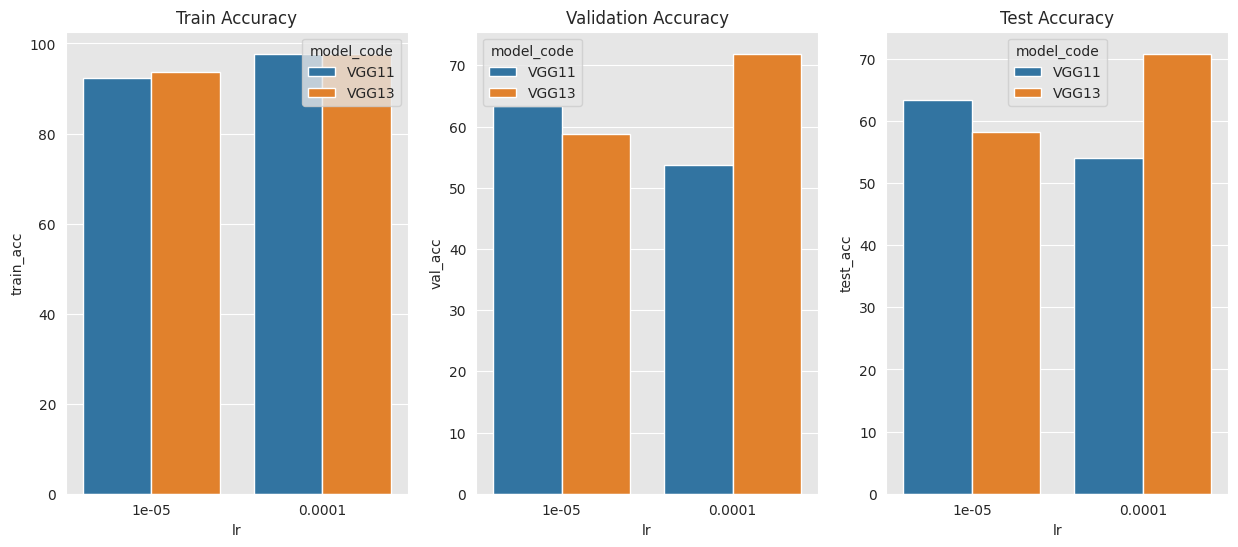

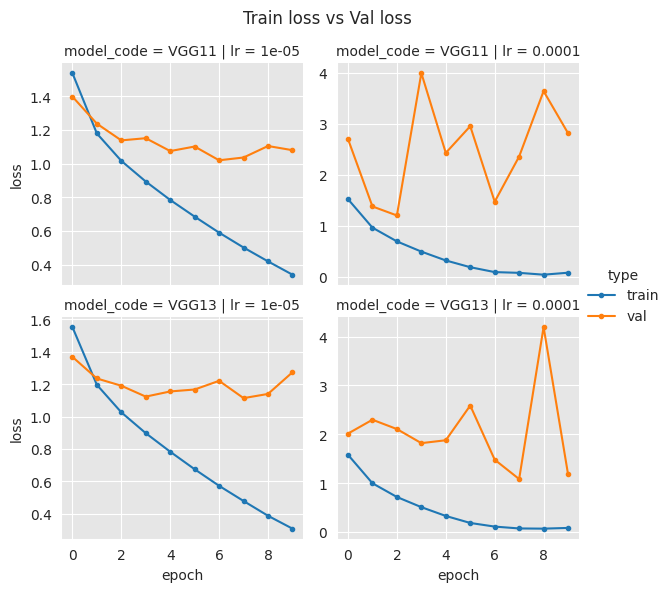

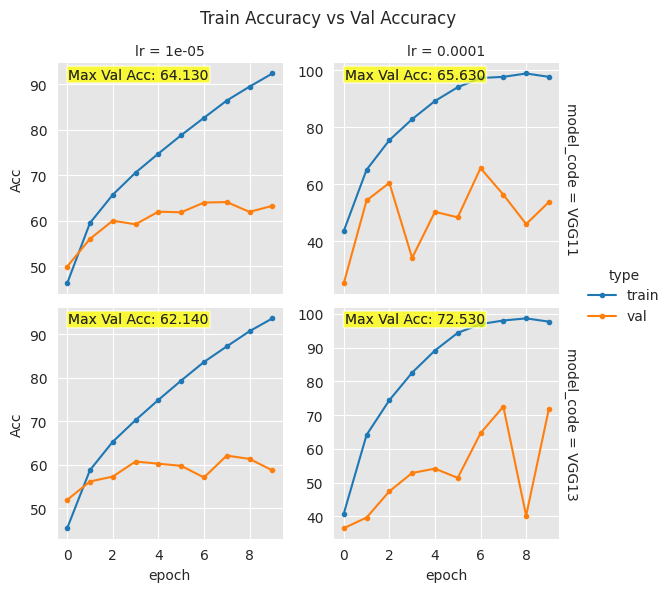

In [ ]:
var1 = 'lr'
var2 = 'model_code'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.